In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf

In [3]:
import math
def sigmoid(x):
    try:
        sig = 1 / (1 + math.exp(-x))
    except:
        sig = 0
    return sig

In [4]:
def relu(x, bound = 100):
    return min(max(0,x),bound)

[*********************100%***********************]  1 of 1 completed


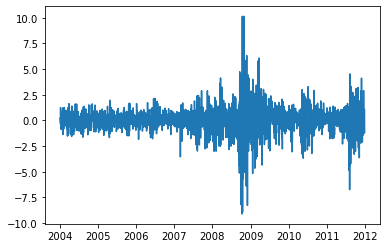

In [5]:
data = yf.download("^GSPC", start="2004-01-01", end="2012-01-01")

data['pct_change'] = data.Open.pct_change()

data['log_ret'] = np.log(data.Open) - np.log(data.Open.shift(1))


data['log_ret * 100'] = data['log_ret'] * 100

returns = data['log_ret * 100'].values[1:]

plt.plot(data['log_ret * 100'])

# 1. MGU GARCH
### Minimal Gated Unit Garch


\begin{align}
y_t &= \sigma_t \epsilon_t \\
\sigma_t^2 &= w_t + \alpha y_{t-1} + \beta \sigma_{t-1}^2 \\
w_t &= f(\gamma_0 + \gamma_1 h_t) \qquad \text{authors always used f(x) = x for this function} \\
h_t &= z_t \hat{h}_t + (1-z_t) h_{t-1} \\
\hat{h}_t &= \phi_\hat{h} (v_1 x_t +  \mu_1 z_t h_{t-1} + b_\hat{h})  \\
z_t &= \phi_z (v_2 x_t + \mu_2 z_{t-1} h_{t-1} + b_z)
\end{align}
I set $b_i = 0$ for all $i$ 

The MGU merges the reset gate "vector" $r_t$ and update gate "vector" $z_t$ into a forget gate "vector" $z_t$. Usually it is called $f_t$ but I merge $z$ and $r$ into $z$.

We have one vector $v$ and one scalar $\mu$ less than in the GRU.

In [42]:
def MGU_garch(alpha, beta, gamma_0, gamma_1, v_11, v_12, v_21, v_22, mu_1, mu_2, nun_lin_func, returns):
    iT = len(returns)
    sigma_2 = np.zeros(iT)
    w = np.zeros(iT)
    h = np.zeros(iT)
    h_hat = np.zeros(iT)
    z = np.zeros(iT)
    for i in range(iT):
        if i == 0:
            sigma_2[i] = 0.1/(1- alpha - beta)
            # w[i] = 0.1/(1- alpha - beta)
        else:
            z[i] = sigmoid(v_21 * returns[i-1] + v_22 * sigma_2[i-1] + mu_2 * z[i-1] * h[i-1]) # here sigmoid instead of ReLU
            h_hat[i] = nun_lin_func(v_11 * returns[i-1] + v_12 * sigma_2[i-1] + mu_1 * z[i] * h[i-1])
            h[i] = nun_lin_func(z[i] * h_hat[i] + (1-z[i]) * h[i-i])
            w[i] = gamma_0 + gamma_1 * h[i]
            sigma_2[i] = w[i] + alpha * returns[i-1]**2 + beta * sigma_2[i-1]
    return sigma_2, w, h

def MGU_garch_loglike(start_v, nun_lin_func, returns):
    iT = len(returns)
    alpha = start_v[0]
    beta = start_v[1]
    gamma_0 = start_v[2]
    gamma_1 = start_v[3]
    v_11 = start_v[4]
    v_12 = start_v[5]
    v_21 = start_v[6]
    v_22 = start_v[7]
    mu_1 = start_v[8]
    mu_2 = start_v[9]
    
    sigma_2 = MGU_garch(alpha, beta, gamma_0, gamma_1, v_11, v_12, v_21, v_22, mu_1, mu_2, nun_lin_func, returns)[0]
    LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)
    return LogL

In [59]:
#cons = ({"type": "ineq", "func" : lambda x: np.array(x)})
vP0 = np.array((0.1, 0.25, 0.52, 0.9 , 0.9, 0.9, 0.9, 0.9, 0.9, 0.9))
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 3),  (-3, 3) , (-10, 10)  ,(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ),(-10,10 ))

res = opt.minimize(MGU_garch_loglike, vP0, args = (relu, returns),
                  bounds = my_bounds,
                    method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

#par_names = ["alpha", "beta", "gamma0", "gamma1",  "v11",  "v2",  "v3",  "v4"]
"""
plt.bar(par_names, res.x)
plt.show()

plt.bar(par_names[4:], res.x[4:])
plt.show()"""

C:\Users\mobem\AppData\Local\Temp\ipykernel_7156\3450895967.py:34: RuntimeWarning: invalid value encountered in log
  LogL = - np.sum(-np.log(sigma_2) -  returns**2/sigma_2)


Optimization terminated successfully.
         Current function value: 1920.726746
         Iterations: 2657
         Function evaluations: 3771


'\nplt.bar(par_names, res.x)\nplt.show()\n\nplt.bar(par_names[4:], res.x[4:])\nplt.show()'

In [60]:
res.x

array([ 0.14806858,  0.60404848,  0.05773642,  0.85153116, -0.74402082,
        0.77656535,  2.8023494 ,  1.38883111, -2.34114096,  2.14308412])

In [61]:
par_names = ["alpha", "beta", "gamma_0", "gamma_1", "v_11", "v_12", "v_21", "v_22", "mu_1", "mu_2"]

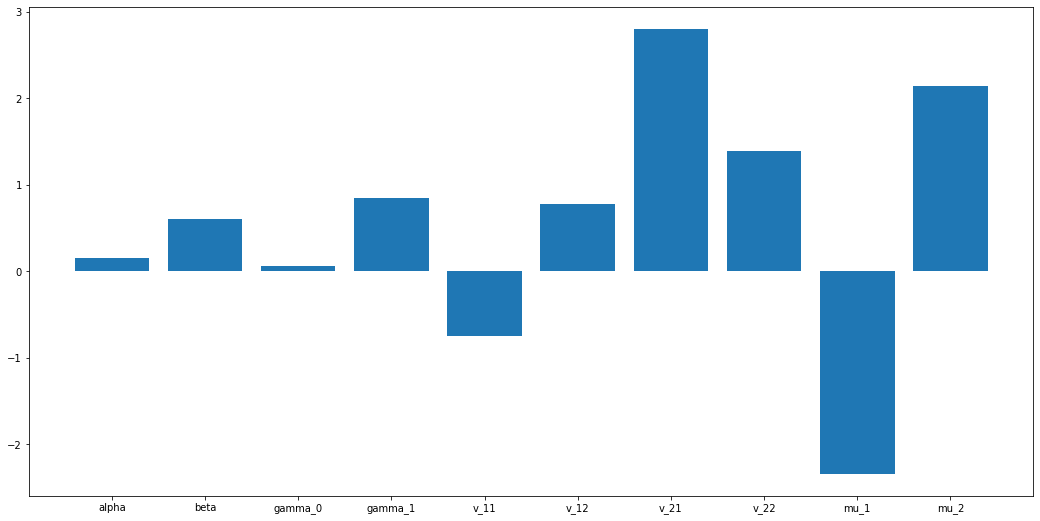

In [62]:
plt.figure(figsize=(18,9))
plt.bar(par_names, res.x)
plt.show()

In [63]:
res.fun

1920.726745945326

In [64]:
s = MGU_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], relu, returns)[0]
w = MGU_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], relu, returns)[1]
h = MGU_garch(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6], res.x[7], res.x[8], res.x[9], relu, returns)[2]

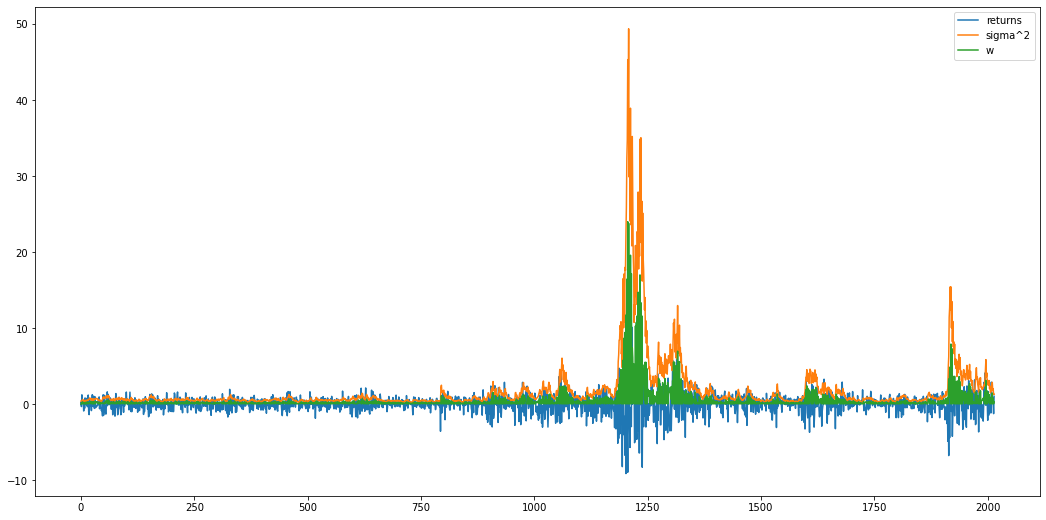

In [65]:
plt.figure(figsize=(18,9))
plt.plot(returns, label = "returns")
plt.plot(s, label = "sigma^2")
plt.plot(w, label = "w")
plt.legend()
plt.show()

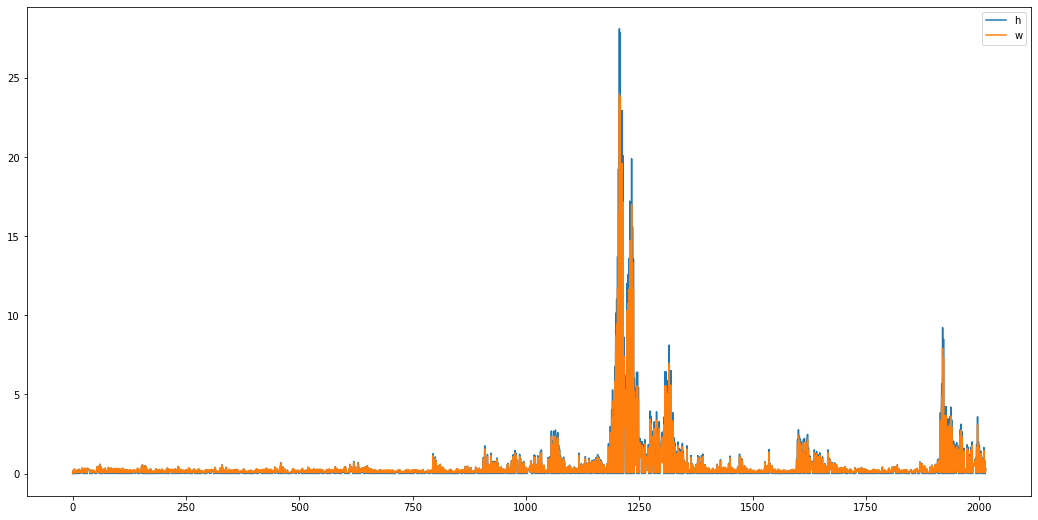

In [66]:
plt.figure(figsize=(18,9))
plt.plot(h, label = "h")
plt.plot(w, label = "w")
plt.legend()
plt.show()